# Dự đoán giá xe ô tô cũ
Tiếp tục với phần trình bày trước, lần này ta sẽ thực hiện nghiên cứu và đánh giá các mô hình hồi quy tối ưu để áp dụng cho bài toán dự đoán giá xe ô tô cũ. Các bước tiến hành gồm:
+ Xử lý các ngoại lệ và chuẩn hóa, mã hóa các đặc trưng
+ Lựa chọn các đặc trưng phù hợp
+ Import và sử dụng các mô hình: Linear Regression, Gradient Boosting,Lasso,Ridge,XGBoost
+ Hiệu chỉnh mô hình và trực quan hóa kết quả
+ Nhận xét

#### Import các thư viện cần thiết

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, LabelEncoder
from category_encoders import TargetEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import warnings
import itertools

#### Đọc dữ liệu từ file  

In [28]:
warnings.filterwarnings('ignore')
data_clean = pd.read_csv("data clean.csv")
%matplotlib inline
data_clean.head(3)

,ID,Hãng xe,Năm sản xuất,Tình trạng,Số Km đã đi,Xuất xứ,Kiểu dáng,Hộp số,Động cơ,Số chỗ ngồi,Dẫn động,Ngày đăng,Địa điểm,Giá
0,xe-ford-everest-ambiente-2.0l-4x2-at-2022-5541828,Ford,2022,Xe đã dùng,30000.000000,Nhập khẩu,SUV,Số tự động,Dầu 2.0 L,7,RFD - Dẫn động cầu sau,4/2024,Hà Nội,1050.0
1,xe-mercedes_benz-glb-200-amg-2024-4925370,Mercedes Benz,2024,Xe mới,0.000000,Nhập khẩu,SUV,Số tự động,Xăng 1.3 L,7,RFD - Dẫn động cầu sau,4/2024,Hà Nội,2089.0
2,xe-toyota-camry-le-2.4-2007-5537945,Toyota,2007,Xe đã dùng,78171.918485,Nhập khẩu,Sedan,Số tự động,Xăng 2.4 L,5,FWD - Dẫn động cầu trước,4/2024,Thanh Hóa,295.0


Xử lý dữ liệu ngoại lệ. Loại bỏ các dữ liệu có cột giá > 10000 và trực quan hóa sự thay đổi

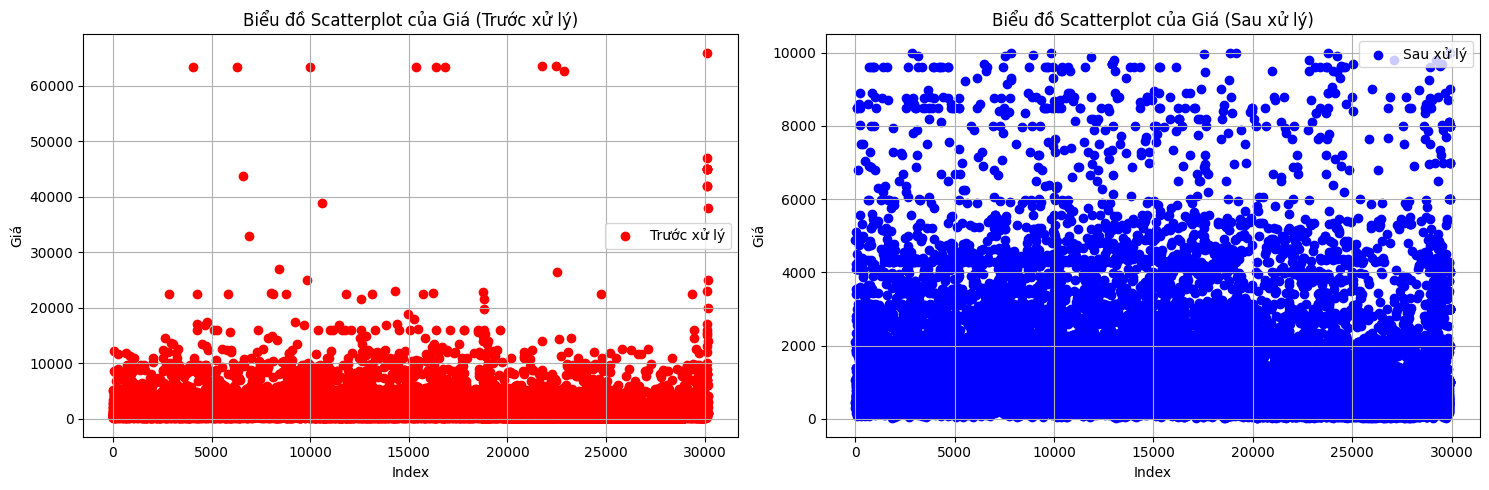

In [29]:
data = data_clean.copy()

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(range(len(data_clean['Giá'])), data_clean['Giá'], label='Trước xử lý', color='r')
plt.title('Biểu đồ Scatterplot của Giá (Trước xử lý)')
plt.xlabel('Index')
plt.ylabel('Giá')
plt.legend()
plt.grid(True)

data = data[data['Giá'] <= 10000]

plt.subplot(1, 2, 2)
plt.scatter(range(len(data['Giá'])), data['Giá'], label='Sau xử lý', color='b')
plt.title('Biểu đồ Scatterplot của Giá (Sau xử lý)')
plt.xlabel('Index')
plt.ylabel('Giá')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Xử lý dữ liệu ngoại lệ. Thay đổi các dữ liệu có cột Số Km đã đi > 500000 bằng 500000 và trực quan hóa sự thay đổi

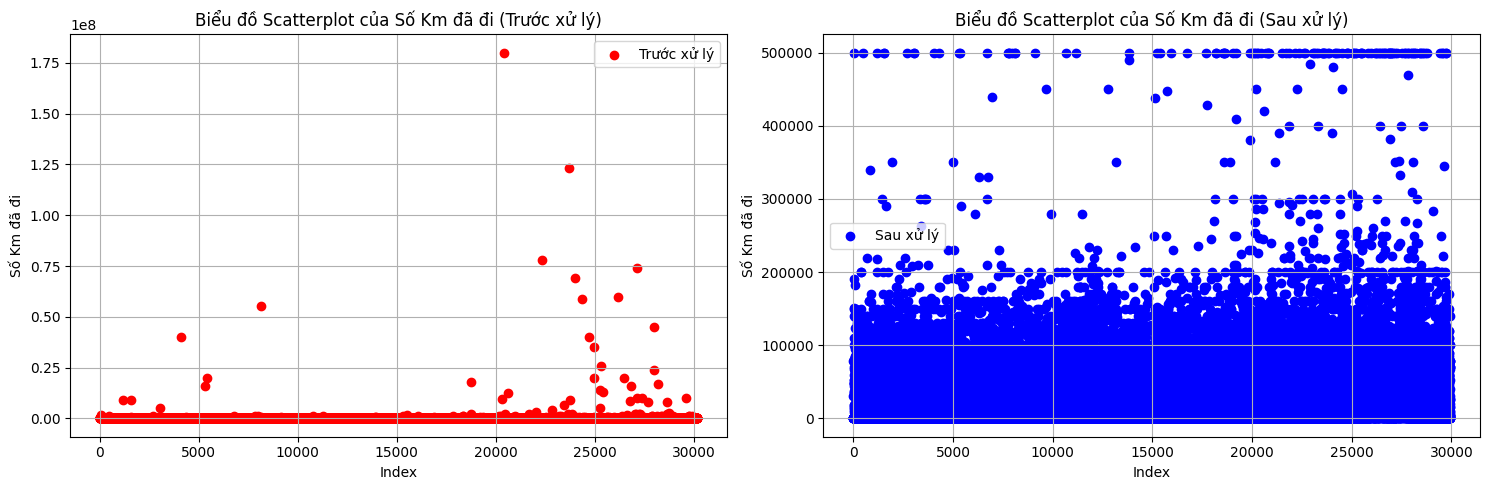

In [30]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(range(len(data_clean['Số Km đã đi'])), data_clean['Số Km đã đi'], label='Trước xử lý', color='r')
plt.title('Biểu đồ Scatterplot của Số Km đã đi (Trước xử lý)')
plt.xlabel('Index')
plt.ylabel('Số Km đã đi')
plt.legend()
plt.grid(True)

data.loc[data['Số Km đã đi'] > 500000, 'Số Km đã đi'] = 500000

plt.subplot(1, 2, 2)
plt.scatter(range(len(data['Số Km đã đi'])), data['Số Km đã đi'], label='Sau xử lý', color='b')
plt.title('Biểu đồ Scatterplot của Số Km đã đi (Sau xử lý)')
plt.xlabel('Index')
plt.ylabel('Số Km đã đi')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Trực quan hóa 3 phương pháp scaling. Với dữ liệu cột 'Số Km đã đi':
+ Dữ liệu có phân phối lệch, không gần chuẩn
+ Dữ liệu còn nhiều giá trị ngoại lệ
+ Các mô hình đã chọn không cần thiết phải chuyển đổi về phân phối chuẩn hoặc phạm vi cụ thể
##### => Sử dụng phương pháp chuẩn hóa Robust Scaling cho cột 'Số Km đã đi' 

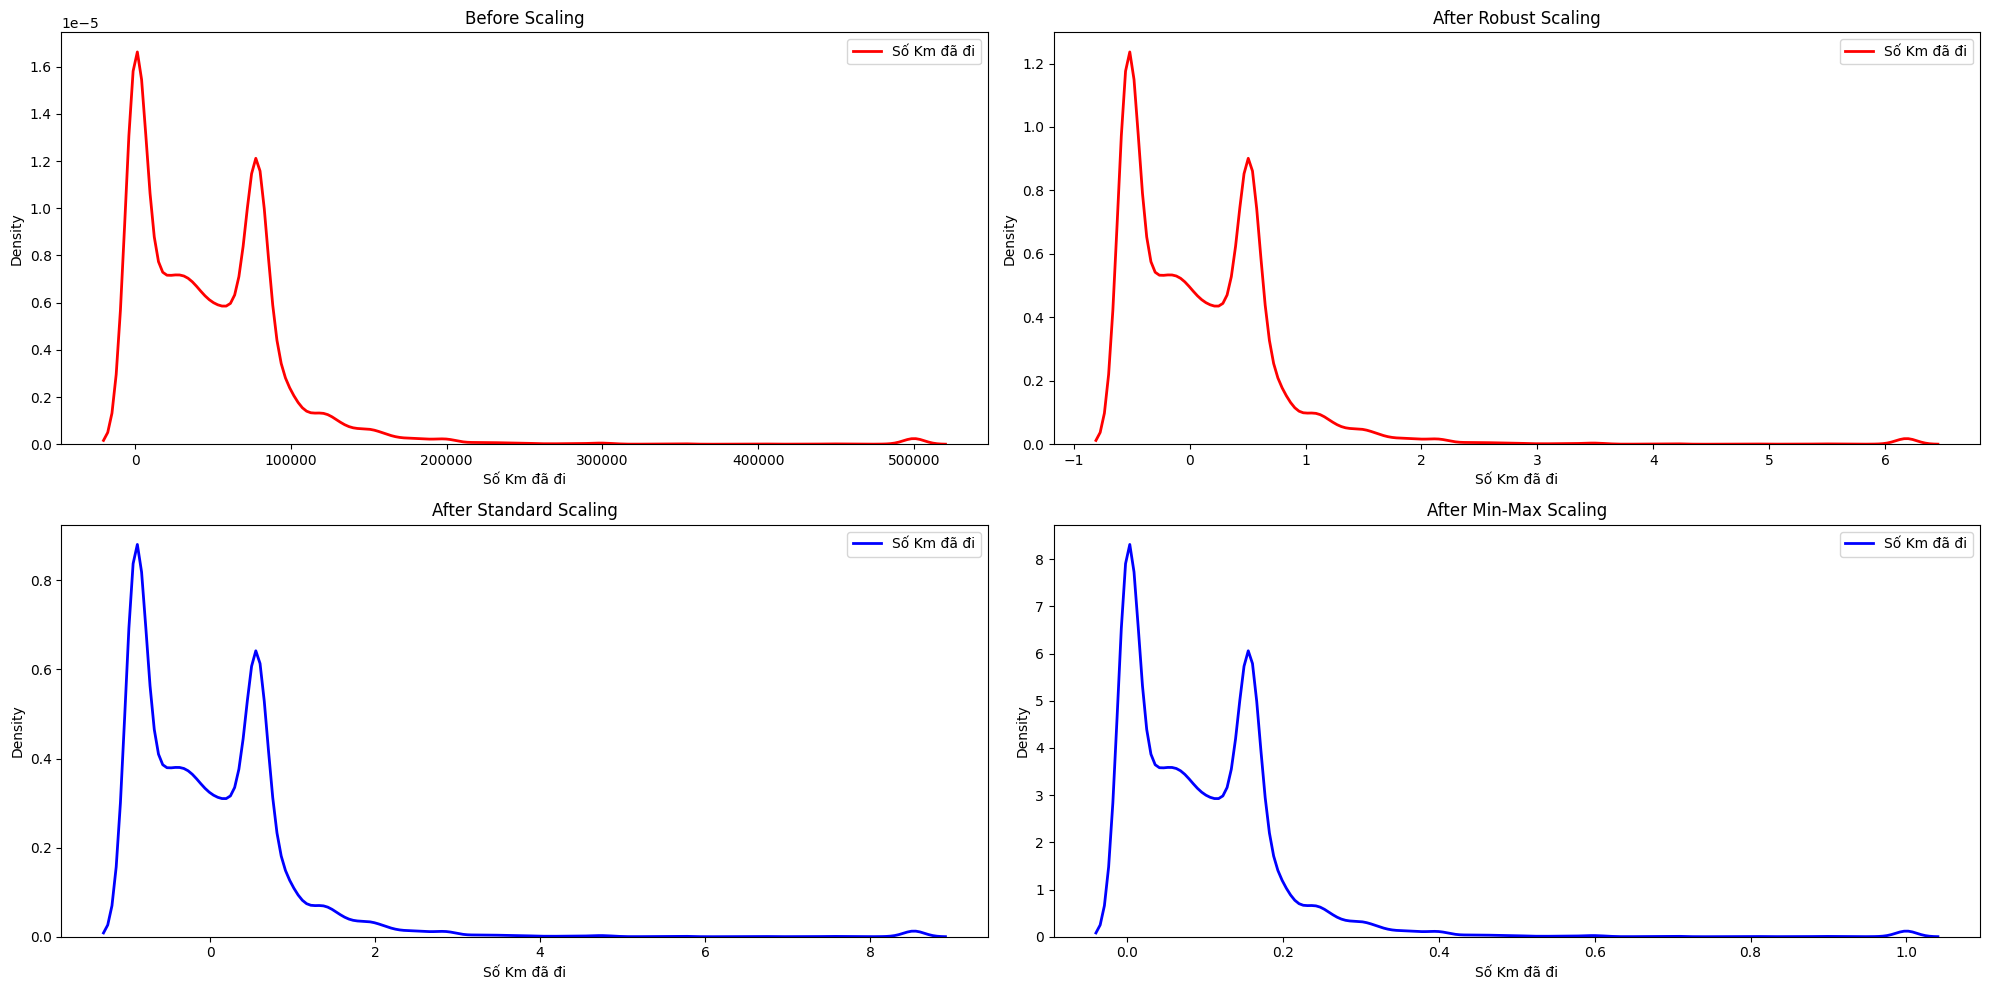

In [13]:
km_data = data['Số Km đã đi']
x = pd.DataFrame({'x1': km_data})

scaler = RobustScaler()
robust_df = scaler.fit_transform(x)
robust_df = pd.DataFrame(robust_df, columns=['x1'])

scaler = StandardScaler()
standard_df = scaler.fit_transform(x)
standard_df = pd.DataFrame(standard_df, columns=['x1'])

scaler = MinMaxScaler()
minmax_df = scaler.fit_transform(x)
minmax_df = pd.DataFrame(minmax_df, columns=['x1'])
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

ax1.set_title('Before Scaling')
ax1.set_xlabel('Số Km đã đi')
sns.kdeplot(x['x1'], ax=ax1, color='r', linewidth=2)
ax1.legend(['Số Km đã đi'])

ax2.set_title('After Robust Scaling')
ax2.set_xlabel('Số Km đã đi')
sns.kdeplot(robust_df['x1'], ax=ax2, color='r', linewidth=2)
ax2.legend(['Số Km đã đi'])

ax3.set_title('After Standard Scaling')
ax3.set_xlabel('Số Km đã đi')
sns.kdeplot(standard_df['x1'], ax=ax3, color='b', linewidth=2)
ax3.legend(['Số Km đã đi'])

ax4.set_title('After Min-Max Scaling')
ax4.set_xlabel('Số Km đã đi')
sns.kdeplot(minmax_df['x1'], ax=ax4, color='b', linewidth=2)
ax4.legend(['Số Km đã đi'])

plt.tight_layout()
plt.show()

#### Chuẩn hóa và mã hóa dữ liệu
- Cột Số Km đã đi chuẩn hóa bằng Robust Scaling
- Cột Hãng xe, Động cơ, Dẫn động, Địa điểm, Kiểu dáng mã hóa bằng target encoder
- Cột Xuất xứ, Tình trạng, Hộp số mã hóa bằng label encoder
- Các cột còn lại không cần mã hóa

In [31]:
selected_columns = ['Năm sản xuất','Tình trạng','Kiểu dáng','Số Km đã đi', 'Xuất xứ', 'Hãng xe', 'Dẫn động', 'Số chỗ ngồi','Địa điểm', 'Động cơ','Hộp số', 'Giá']
data = data[selected_columns].copy()

robust_scaler = RobustScaler()
data['Số Km đã đi'] = robust_scaler.fit_transform(data[['Số Km đã đi']])
data['Giá'] = robust_scaler.fit_transform(data[['Giá']])


target_encoder = TargetEncoder()
label_encoder = LabelEncoder()

data['Hãng xe'] = label_encoder.fit_transform(data['Hãng xe'])
data['Động cơ'] = label_encoder.fit_transform(data['Động cơ'])
data['Dẫn động'] = label_encoder.fit_transform(data['Dẫn động'])
data['Địa điểm'] = label_encoder.fit_transform(data['Địa điểm'])
data['Kiểu dáng'] = label_encoder.fit_transform(data['Kiểu dáng'])

data['Xuất xứ'] = label_encoder.fit_transform(data['Xuất xứ'])
data['Tình trạng'] = label_encoder.fit_transform(data['Tình trạng'])
data['Hộp số'] = label_encoder.fit_transform(data['Hộp số'])

data.to_csv("datack.csv", index=False)
data.head(5)

,Năm sản xuất,Tình trạng,Kiểu dáng,Số Km đã đi,Xuất xứ,Hãng xe,Dẫn động,Số chỗ ngồi,Địa điểm,Động cơ,Hộp số,Giá
0,2022,Xe đã dùng,SUV,30000.000000,Nhập khẩu,Ford,RFD - Dẫn động cầu sau,7,Hà Nội,Dầu 2.0 L,Số tự động,1050.0
1,2024,Xe mới,SUV,0.000000,Nhập khẩu,Mercedes Benz,RFD - Dẫn động cầu sau,7,Hà Nội,Xăng 1.3 L,Số tự động,2089.0
2,2007,Xe đã dùng,Sedan,78171.918485,Nhập khẩu,Toyota,FWD - Dẫn động cầu trước,5,Thanh Hóa,Xăng 2.4 L,Số tự động,295.0
3,2024,Xe mới,SUV,0.000000,Nhập khẩu,Mercedes Benz,AWD - 4 bánh toàn thời gian,7,Hà Nội,Xăng 3.0 L,Số tự động,4880.0
4,2023,Xe mới,SUV,0.000000,Nhập khẩu,Suzuki,FWD - Dẫn động cầu trước,7,TP HCM,Hybrid 1.5 L,Số tay,449.0


#### Trích xuất đặc trưng dùng 2 cách để so sánh:

- Dựa vào đồ thị Heatmap để lựa chọn các đặc trưng có hệ số tương quan lớn
- Sau khi có mô hình duyệt qua các đặc trưng để lựa chọn đặc trưng phù hợp

Đoạn mã vẽ heatmap để quan sát hệ số tương quan giữa các đặc trưng với biến mục tiêu (Để so sánh nếu hệ số tương quan càng cao thì khả năng nhận dạng càng cao không)

<Axes: >

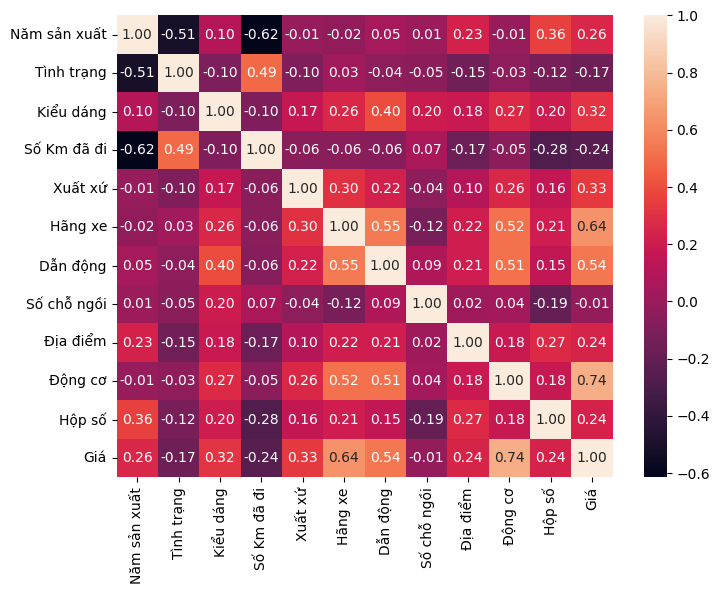

In [350]:
plt.figure(figsize=(8,6))
sns.heatmap(data.corr(numeric_only=True), annot=True,fmt=".2f")

- Trường hợp 2 lựa chọn toàn bộ đặc trưng và tách riêng biến mục tiêu khỏi tập dữ liệu

In [351]:
X = data.drop('Giá', axis=1)
y = data['Giá']

- Chia dữ liệu gốc thành 2 tập train và validation

In [352]:
train_X, validation_X, train_y, validation_y = train_test_split(X, y, test_size=0.3, random_state=2)

- Sử dụng mô hình Linear Regression 

In [353]:
linear_model = LinearRegression()

linear_model.fit(train_X, train_y)
linear_score_train = linear_model.score(train_X, train_y)
linear_score_validation = linear_model.score(validation_X, validation_y)

print("Train Score (X, y):", linear_score_train)
print("Validation Score (X, y):", linear_score_validation)

Train Score (X, y): 0.727673129515515
Validation Score (X, y): 0.7269342159388822


- Sử dụng mô hình GradientBoosting

In [354]:
gb_model = GradientBoostingRegressor()

gb_model.fit(train_X, train_y)
gb_score_train = gb_model.score(train_X, train_y)
gb_score_validation = gb_model.score(validation_X, validation_y)

print("Train Score (X, y):", gb_score_train)
print("Validation Score (X, y):", gb_score_validation)

Train Score (X, y): 0.9265244033649465
Validation Score (X, y): 0.9232119961904185


- Sử dụng mô hình Lasso

In [355]:
lasso_model = Lasso(alpha=100, max_iter=1000, tol=0.1)

lasso_model.fit(train_X, train_y)
lasso_score_train = lasso_model.score(train_X, train_y)
lasso_score_validation = lasso_model.score(validation_X, validation_y)

print("Train Score (X, y):", lasso_score_train)
print("Validation Score (X, y):", lasso_score_validation)

Train Score (X, y): 0.7171731645667961
Validation Score (X, y): 0.7184515107784423


- Sử dụng mô hình Ridge

In [356]:
ridge_model = Ridge(alpha=100)

ridge_model.fit(train_X, train_y)
ridge_score_train = ridge_model.score(train_X, train_y)
ridge_score_validation = ridge_model.score(validation_X, validation_y)

print("Train Score (X, y):", ridge_score_train)
print("Validation Score (X, y):", ridge_score_validation)

Train Score (X, y): 0.7276627443808557
Validation Score (X, y): 0.7269708779105772


- Sử dụng mô hinh XgBoost

In [357]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}
num_rounds = 100

dtrain_reg = xgb.DMatrix(train_X, train_y, enable_categorical=True)
dtest_reg = xgb.DMatrix(validation_X, validation_y, enable_categorical=True)

xgb_model = xgb.train(params, dtrain_reg, num_rounds)
train_pred_xgb = xgb_model.predict(dtrain_reg)
test_pred_xgb = xgb_model.predict(dtest_reg)
train_rmse_xgb = mean_squared_error(train_y, train_pred_xgb, squared=False)
test_rmse_xgb = mean_squared_error(validation_y, test_pred_xgb, squared=False)
r2_train_xgb = r2_score(train_y, train_pred_xgb)
r2_test_xgb = r2_score(validation_y, test_pred_xgb)

print("Train Score (X, y):", r2_train_xgb)
print("Validation Score (X, y):", r2_test_xgb)

Train Score (X, y): 0.9886371621084145
Validation Score (X, y): 0.9699789661481601


### Nhận xét:
- Qua kết quả của 5 mô hình trên thấy đa phần các mô hình không bị hiện tượng quá khớp, dưới khớp. Kết quả của tập train và tập validation tương đối gần nhau 
- Ta có thể thấy mô hình Linear, Lasso và Ridge tương đối thấp 
- Mô hình Gradient Boosting và đặc biệt là xgBoost có điểm số cao hơn đáng kể

In [358]:
k = 5
kf = KFold(n_splits=k)

linear_model = LinearRegression()
gb_model = GradientBoostingRegressor()
lasso_model = Lasso(alpha=2, max_iter=1000, tol=0.1)
ridge_model = Ridge(alpha=10)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}
num_rounds = 100

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)

models = [('Linear Regression', linear_model), ('Gradient Boosting', gb_model), ('Lasso', lasso_model), ('Ridge', ridge_model), ('XGBoost', xgb_model)]

results = pd.DataFrame(columns=['Model', 'Train Scores', 'Validation Scores'])

for model_name, model in models:
    train_scores = []
    test_scores = []
    for train_index, test_index in kf.split(train_X):
        X_train_kf, X_test_kf = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train_kf, y_test_kf = train_y.iloc[train_index], train_y.iloc[test_index]
        
        if model_name == 'XGBoost':
            dtrain_reg = xgb.DMatrix(X_train_kf, y_train_kf, enable_categorical=True)
            dtest_reg = xgb.DMatrix(X_test_kf, y_test_kf, enable_categorical=True)
            xgb_model = xgb.train(params, dtrain_reg, num_rounds)
            train_score = r2_score(y_train_kf, xgb_model.predict(dtrain_reg))
            test_score = r2_score(y_test_kf, xgb_model.predict(dtest_reg))
        else:
            model.fit(X_train_kf, y_train_kf)
            train_score = model.score(X_train_kf, y_train_kf)
            test_score = model.score(X_test_kf, y_test_kf)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    results_df = pd.DataFrame({
        'Model': [model_name]*len(train_scores),
        'Train Scores': train_scores,
        'Validation Scores': test_scores
    })
    
    results = pd.concat([results, results_df], ignore_index=True)

print(results)

                Model  Train Scores  Validation Scores
0   Linear Regression      0.723636           0.741826
1   Linear Regression      0.726653           0.731606
2   Linear Regression      0.729445           0.720102
3   Linear Regression      0.732105           0.706542
4   Linear Regression      0.726731           0.731056
5   Gradient Boosting      0.927792           0.916478
6   Gradient Boosting      0.928480           0.917788
7   Gradient Boosting      0.926746           0.918323
8   Gradient Boosting      0.928255           0.919477
9   Gradient Boosting      0.925284           0.921269
10              Lasso      0.723580           0.741755
11              Lasso      0.726601           0.731382
12              Lasso      0.729390           0.720322
13              Lasso      0.732051           0.706627
14              Lasso      0.726681           0.730915
15              Ridge      0.723636           0.741824
16              Ridge      0.726652           0.731601
17        

##### Nhận xét
- Dựa vào kết quả ta có thể thấy, tuy Lasso và Ridge có điểm số tương đối thấp nhưng có thể hội tụ ổn định hơn so với Linear Regression vì điểm số giữa các lần chạy ít biến động hơn
- Đặc biệt mô hình Xgboots có điểm số rất cao và ổn định giữa các lần chạy. Điều này cho thấy mô hình này có khả năng dự đoán ổn định và chính xác nhất

Sau khi có mô hình, thực hiện so sánh cách lựa chọn đặc trưng phù hợp bằng cách duyệt qua tất cả các trường hợp chọn 8, 9, 10 hoặc 11 trên tất cả các đặc trưng. Sau đó so sánh tổ hợp đặc trưng được chọn nào cho ra kết quả tốt nhất

Hàm duyệt qua tất cả trường hợp lựa chọn k đặc trưng trên toàn bộ đặc trưng của tập dữ liệu

In [359]:
def selected_feature(num):
    all_columns = X.columns

    results = pd.DataFrame(columns=['Model', 'Train Score', 'Test Score', 'Selected Columns'])

    # Iterate through all combinations of k columns
    for selected_columns in itertools.combinations(all_columns, num):
        # Select features
        selected_features = X[list(selected_columns)]
        
        # Split data into train and test sets
        train_X, test_X, train_y, test_y = train_test_split(selected_features, y, test_size=0.3, random_state=2)
        # Train the XGBoost model
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse'
        }
        num_rounds = 100
        dtrain_reg = xgb.DMatrix(train_X, train_y, enable_categorical=True)
        dtest_reg = xgb.DMatrix(test_X, test_y, enable_categorical=True)
        xgb_model = xgb.train(params, dtrain_reg, num_rounds)

        # Make predictions
        train_pred_xgb = xgb_model.predict(dtrain_reg)
        test_pred_xgb = xgb_model.predict(dtest_reg)

        # Evaluate the XGBoost model
        train_rmse_xgb = mean_squared_error(train_y, train_pred_xgb, squared=False)
        test_rmse_xgb = mean_squared_error(test_y, test_pred_xgb, squared=False)
        r2_train_xgb = r2_score(train_y, train_pred_xgb)
        r2_test_xgb = r2_score(test_y, test_pred_xgb)

        # Define models
        linear_model = LinearRegression()
        gb_model = GradientBoostingRegressor()
        lasso_model = Lasso(alpha=2, max_iter=1000, tol=0.1)
        ridge_model = Ridge(alpha=10)
        
        # Train models
        linear_model.fit(train_X, train_y)
        gb_model.fit(train_X, train_y)
        lasso_model.fit(train_X, train_y)
        ridge_model.fit(train_X, train_y)
        
        # Evaluate models
        linear_score_train = linear_model.score(train_X, train_y)
        gb_score_train = gb_model.score(train_X, train_y)
        lasso_score_train = lasso_model.score(train_X, train_y)
        ridge_score_train = ridge_model.score(train_X, train_y)
        
        linear_score_test = linear_model.score(test_X, test_y)
        gb_score_test = gb_model.score(test_X, test_y)
        lasso_score_test = lasso_model.score(test_X, test_y)
        ridge_score_test = ridge_model.score(test_X, test_y)
        
        # Append results to DataFrame
        data = [
            {'Model': 'Linear Regression', 'Train Score': linear_score_train, 'Test Score': linear_score_test, 'Selected Columns': selected_columns},
            {'Model': 'Gradient Boosting', 'Train Score': gb_score_train, 'Test Score': gb_score_test, 'Selected Columns': selected_columns},
            {'Model': 'Lasso', 'Train Score': lasso_score_train, 'Test Score': lasso_score_test, 'Selected Columns': selected_columns},
            {'Model': 'Ridge', 'Train Score': ridge_score_train, 'Test Score': ridge_score_test, 'Selected Columns': selected_columns},
            {'Model': 'XGBoost', 'Train Score': r2_train_xgb, 'Test Score': r2_test_xgb, 'Selected Columns': selected_columns}
        ]
        results = pd.concat([results, pd.DataFrame(data)], ignore_index=True)
    return results
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

Tính toán kết quả điểm của tất cả trường hợp khi chọn 8, 9, 10, 11 đặc trưng trên toàn bộ đặc trưng

In [361]:
data_8 = selected_feature(8)
data_9 = selected_feature(9)
data_10 = selected_feature(10)
data_11 = selected_feature(11)

Tính toán score nhỏ nhất cho trường hợp chọn 8 đặc trưng ngẫu nhiên

In [362]:
highest_score_8 = data_8.loc[data_8.groupby('Model')['Validation Score'].idxmax()][['Model', 'Validation Score', 'Selected Columns']]
lowest_score_8 = data_8.loc[data_8.groupby('Model')['Validation Score'].idxmin()][['Model', 'Validation Score', 'Selected Columns']]
lowest_score_8

,Model,Validation Score,Selected Columns
86,Gradient Boosting,0.480437,"('Năm sản xuất', 'Tình trạng', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Số chỗ ngồi', 'Địa điểm', 'Hộp số')"
87,Lasso,0.262987,"('Năm sản xuất', 'Tình trạng', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Số chỗ ngồi', 'Địa điểm', 'Hộp số')"
85,Linear Regression,0.263198,"('Năm sản xuất', 'Tình trạng', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Số chỗ ngồi', 'Địa điểm', 'Hộp số')"
88,Ridge,0.263198,"('Năm sản xuất', 'Tình trạng', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Số chỗ ngồi', 'Địa điểm', 'Hộp số')"
89,XGBoost,0.555784,"('Năm sản xuất', 'Tình trạng', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Số chỗ ngồi', 'Địa điểm', 'Hộp số')"


Tính toán score lớn nhất cho trường hợp chọn 8 đặc trưng ngẫu nhiên

In [363]:
highest_score_8

,Model,Validation Score,Selected Columns
426,Gradient Boosting,0.920911,"('Năm sản xuất', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Hãng xe', 'Dẫn động', 'Số chỗ ngồi', 'Động cơ')"
447,Lasso,0.726630,"('Năm sản xuất', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Hãng xe', 'Dẫn động', 'Động cơ', 'Hộp số')"
445,Linear Regression,0.726536,"('Năm sản xuất', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Hãng xe', 'Dẫn động', 'Động cơ', 'Hộp số')"
448,Ridge,0.726543,"('Năm sản xuất', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Hãng xe', 'Dẫn động', 'Động cơ', 'Hộp số')"
574,XGBoost,0.970536,"('Năm sản xuất', 'Số Km đã đi', 'Xuất xứ', 'Hãng xe', 'Dẫn động', 'Số chỗ ngồi', 'Động cơ', 'Hộp số')"


Tính toán score nhỏ nhất cho trường hợp chọn 9 đặc trưng ngẫu nhiên

In [364]:
highest_score_9 = data_9.loc[data_9.groupby('Model')['Validation Score'].idxmax()][['Model', 'Validation Score', 'Selected Columns']]
lowest_score_9 = data_9.loc[data_9.groupby('Model')['Validation Score'].idxmin()][['Model', 'Validation Score', 'Selected Columns']]
lowest_score_9

,Model,Validation Score,Selected Columns
56,Gradient Boosting,0.686079,"('Năm sản xuất', 'Tình trạng', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Dẫn động', 'Số chỗ ngồi', 'Địa điểm', 'Hộp số')"
57,Lasso,0.418961,"('Năm sản xuất', 'Tình trạng', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Dẫn động', 'Số chỗ ngồi', 'Địa điểm', 'Hộp số')"
55,Linear Regression,0.419110,"('Năm sản xuất', 'Tình trạng', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Dẫn động', 'Số chỗ ngồi', 'Địa điểm', 'Hộp số')"
58,Ridge,0.419117,"('Năm sản xuất', 'Tình trạng', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Dẫn động', 'Số chỗ ngồi', 'Địa điểm', 'Hộp số')"
59,XGBoost,0.765042,"('Năm sản xuất', 'Tình trạng', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Dẫn động', 'Số chỗ ngồi', 'Địa điểm', 'Hộp số')"


Tính toán score lớn nhất cho trường hợp chọn 9 đặc trưng ngẫu nhiên

In [365]:
highest_score_9

,Model,Validation Score,Selected Columns
191,Gradient Boosting,0.921771,"('Năm sản xuất', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Hãng xe', 'Dẫn động', 'Số chỗ ngồi', 'Động cơ', 'Hộp số')"
192,Lasso,0.727156,"('Năm sản xuất', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Hãng xe', 'Dẫn động', 'Số chỗ ngồi', 'Động cơ', 'Hộp số')"
190,Linear Regression,0.727084,"('Năm sản xuất', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Hãng xe', 'Dẫn động', 'Số chỗ ngồi', 'Động cơ', 'Hộp số')"
193,Ridge,0.727091,"('Năm sản xuất', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Hãng xe', 'Dẫn động', 'Số chỗ ngồi', 'Động cơ', 'Hộp số')"
224,XGBoost,0.970609,"('Năm sản xuất', 'Số Km đã đi', 'Xuất xứ', 'Hãng xe', 'Dẫn động', 'Số chỗ ngồi', 'Địa điểm', 'Động cơ', 'Hộp số')"


Tính toán score nhỏ nhất cho trường hợp chọn 10 đặc trưng ngẫu nhiên

In [366]:
highest_score_10 = data_10.loc[data_10.groupby('Model')['Validation Score'].idxmax()][['Model', 'Validation Score', 'Selected Columns']]
lowest_score_10 = data_10.loc[data_10.groupby('Model')['Validation Score'].idxmin()][['Model', 'Validation Score', 'Selected Columns']]
lowest_score_10

,Model,Validation Score,Selected Columns
6,Gradient Boosting,0.819279,"('Năm sản xuất', 'Tình trạng', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Hãng xe', 'Dẫn động', 'Số chỗ ngồi', 'Địa điểm', 'Hộp số')"
7,Lasso,0.546490,"('Năm sản xuất', 'Tình trạng', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Hãng xe', 'Dẫn động', 'Số chỗ ngồi', 'Địa điểm', 'Hộp số')"
5,Linear Regression,0.546320,"('Năm sản xuất', 'Tình trạng', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Hãng xe', 'Dẫn động', 'Số chỗ ngồi', 'Địa điểm', 'Hộp số')"
8,Ridge,0.546325,"('Năm sản xuất', 'Tình trạng', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Hãng xe', 'Dẫn động', 'Số chỗ ngồi', 'Địa điểm', 'Hộp số')"
9,XGBoost,0.913128,"('Năm sản xuất', 'Tình trạng', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Hãng xe', 'Dẫn động', 'Số chỗ ngồi', 'Địa điểm', 'Hộp số')"


Tính toán score lớn nhất cho trường hợp chọn 10 đặc trưng ngẫu nhiên

In [367]:
highest_score_10

,Model,Validation Score,Selected Columns
46,Gradient Boosting,0.923194,"('Năm sản xuất', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Hãng xe', 'Dẫn động', 'Số chỗ ngồi', 'Địa điểm', 'Động cơ', 'Hộp số')"
47,Lasso,0.727150,"('Năm sản xuất', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Hãng xe', 'Dẫn động', 'Số chỗ ngồi', 'Địa điểm', 'Động cơ', 'Hộp số')"
45,Linear Regression,0.727082,"('Năm sản xuất', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Hãng xe', 'Dẫn động', 'Số chỗ ngồi', 'Địa điểm', 'Động cơ', 'Hộp số')"
48,Ridge,0.727089,"('Năm sản xuất', 'Kiểu dáng', 'Số Km đã đi', 'Xuất xứ', 'Hãng xe', 'Dẫn động', 'Số chỗ ngồi', 'Địa điểm', 'Động cơ', 'Hộp số')"
44,XGBoost,0.971602,"('Năm sản xuất', 'Tình trạng', 'Số Km đã đi', 'Xuất xứ', 'Hãng xe', 'Dẫn động', 'Số chỗ ngồi', 'Địa điểm', 'Động cơ', 'Hộp số')"


Lấy ra giá dự đoán và giá thực tế của tập validation

In [368]:
number_of_cars = 300
y_pred_gradient = gb_model.predict(validation_X)
y_pred_linear = linear_model.predict(validation_X)
y_pred_lasso = lasso_model.predict(validation_X)
y_pred_ridge = ridge_model.predict(validation_X)

before_and_after_price = pd.DataFrame({'Giá': validation_y, 'Gradient': y_pred_gradient, 'Linear': y_pred_linear, 'Lasso': y_pred_lasso, 'Ridge': y_pred_ridge}).sample(n=number_of_cars, random_state=42)
full_before_and_after_price = pd.DataFrame({'Giá': validation_y, 'Gradient': y_pred_gradient, 'Linear': y_pred_linear, 'Lasso': y_pred_lasso, 'Ridge': y_pred_ridge})


##### Giá trung bình thực tế và dự đoán của 4 mô hình trên tập validation

<Figure size 1500x600 with 0 Axes>

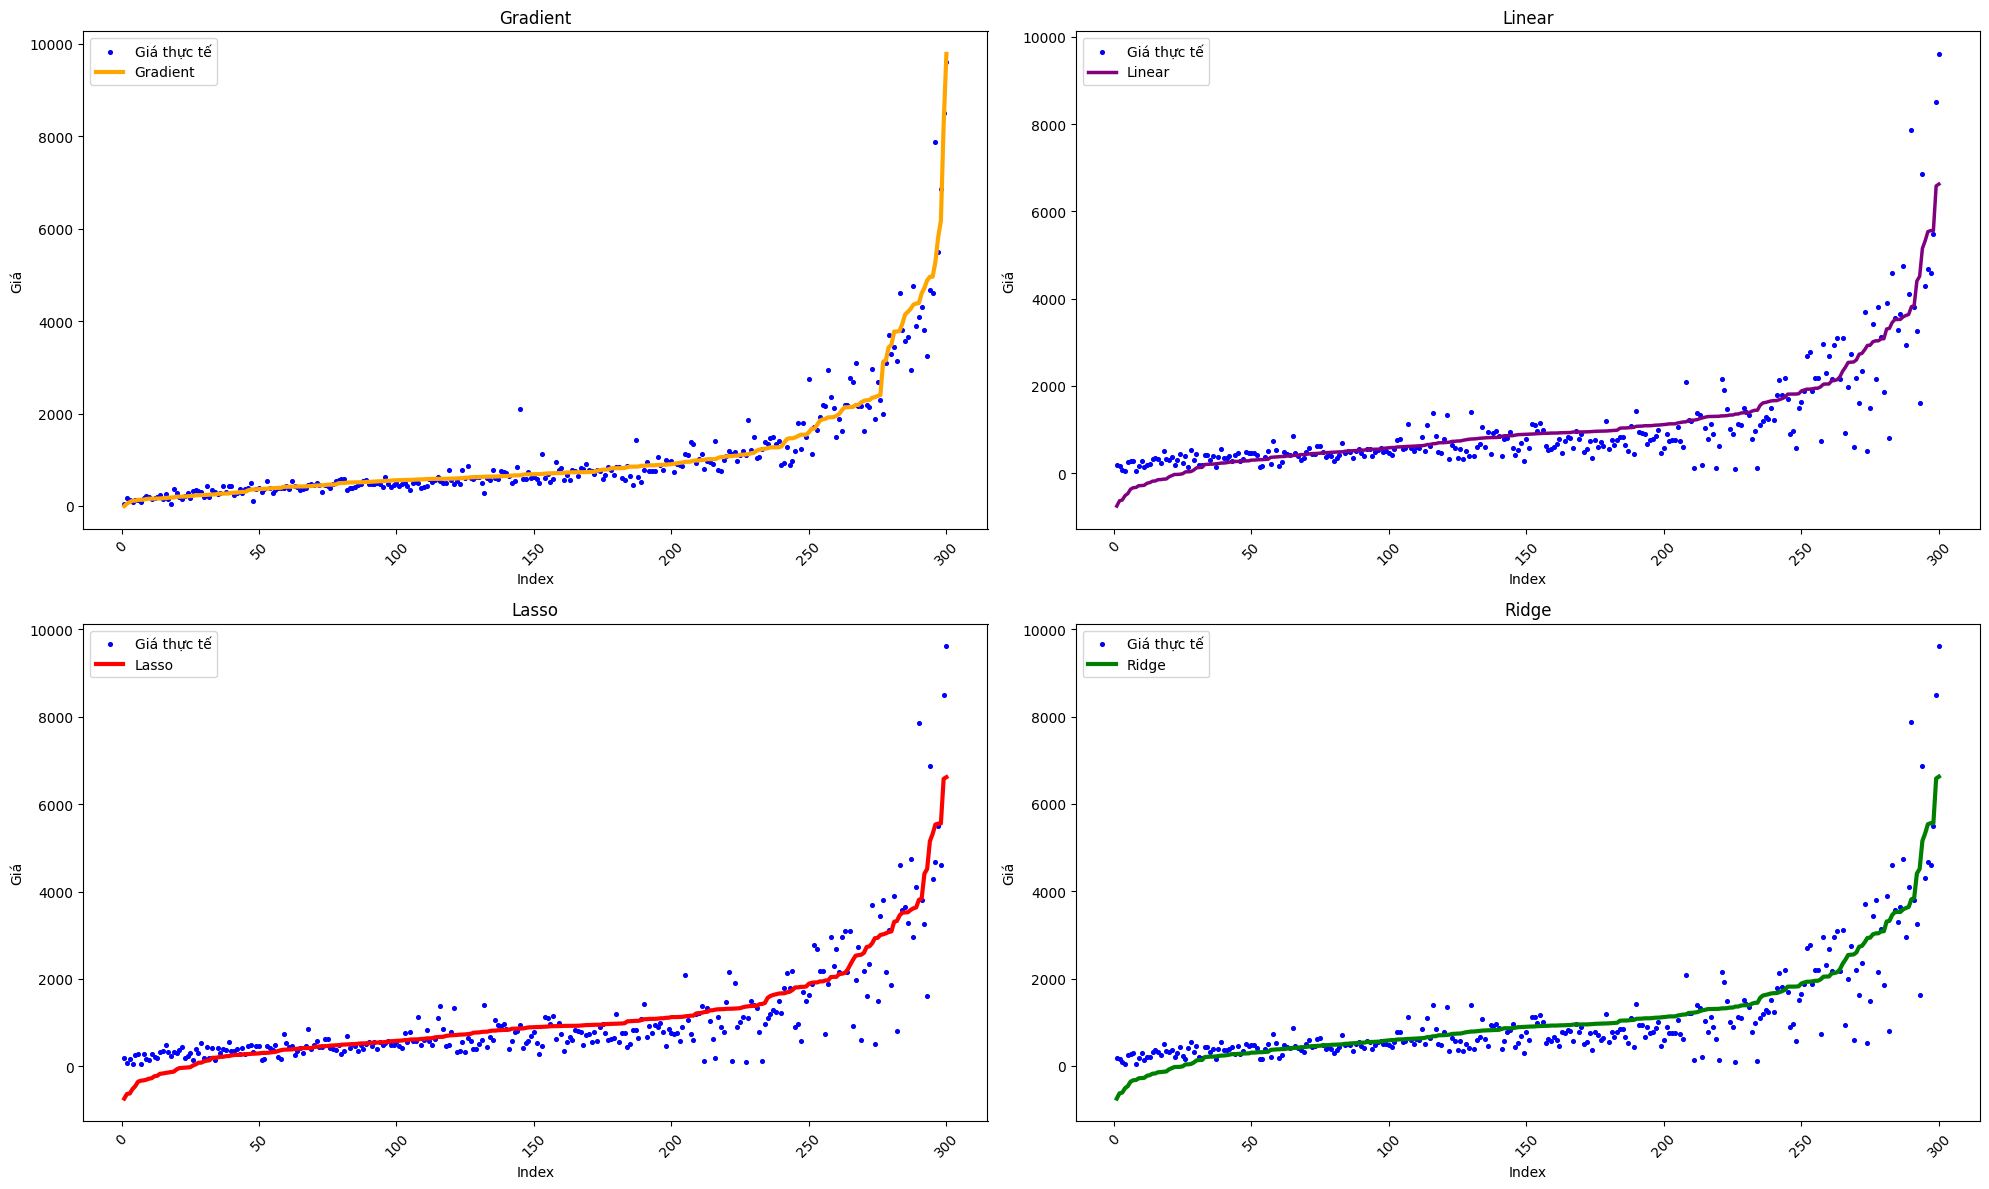

In [369]:
plt.figure(figsize=(15, 6))

fig, axs = plt.subplots(2, 2, figsize=(20, 12))
x_values = range(1, len(before_and_after_price) + 1)

before_and_after_price = before_and_after_price.sort_values('Gradient')
axs[0, 0].scatter(x_values, before_and_after_price['Giá'], color='blue', label='Giá thực tế', s = 7)
axs[0, 0].plot(x_values, before_and_after_price['Gradient'], color='orange', label='Gradient', linewidth=3)
axs[0, 0].set_title('Gradient')
axs[0, 0].set_xlabel('Index')
axs[0, 0].set_ylabel('Giá')
axs[0, 0].tick_params(axis='x', rotation=45)

before_and_after_price = before_and_after_price.sort_values('Linear')
axs[0, 1].scatter(x_values, before_and_after_price['Giá'], color='blue', label='Giá thực tế', s = 7)
axs[0, 1].plot(x_values, before_and_after_price['Linear'], color='purple', label='Linear', linewidth=2.5)
axs[0, 1].set_title('Linear')
axs[0, 1].set_xlabel('Index')
axs[0, 1].set_ylabel('Giá')
axs[0, 1].tick_params(axis='x', rotation=45)

before_and_after_price = before_and_after_price.sort_values('Lasso')
axs[1, 0].scatter(x_values, before_and_after_price['Giá'], color='blue', label='Giá thực tế', s = 7)
axs[1, 0].plot(x_values, before_and_after_price['Lasso'], color='red', label='Lasso', linewidth=3)
axs[1, 0].set_title('Lasso')
axs[1, 0].set_xlabel('Index')
axs[1, 0].set_ylabel('Giá')
axs[1, 0].tick_params(axis='x', rotation=45)

before_and_after_price = before_and_after_price.sort_values('Ridge')
axs[1, 1].scatter(x_values, before_and_after_price['Giá'], color='blue', label='Giá thực tế', s = 7)
axs[1, 1].plot(x_values, before_and_after_price['Ridge'], color='green', label='Ridge', linewidth=3)
axs[1, 1].set_title('Ridge')
axs[1, 1].set_xlabel('Index')
axs[1, 1].set_ylabel('Giá')
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 1].legend()
axs[1, 0].legend()

plt.show()

##### Giá trung bình thực tế và dự đoán theo khoảng giá của tập validation

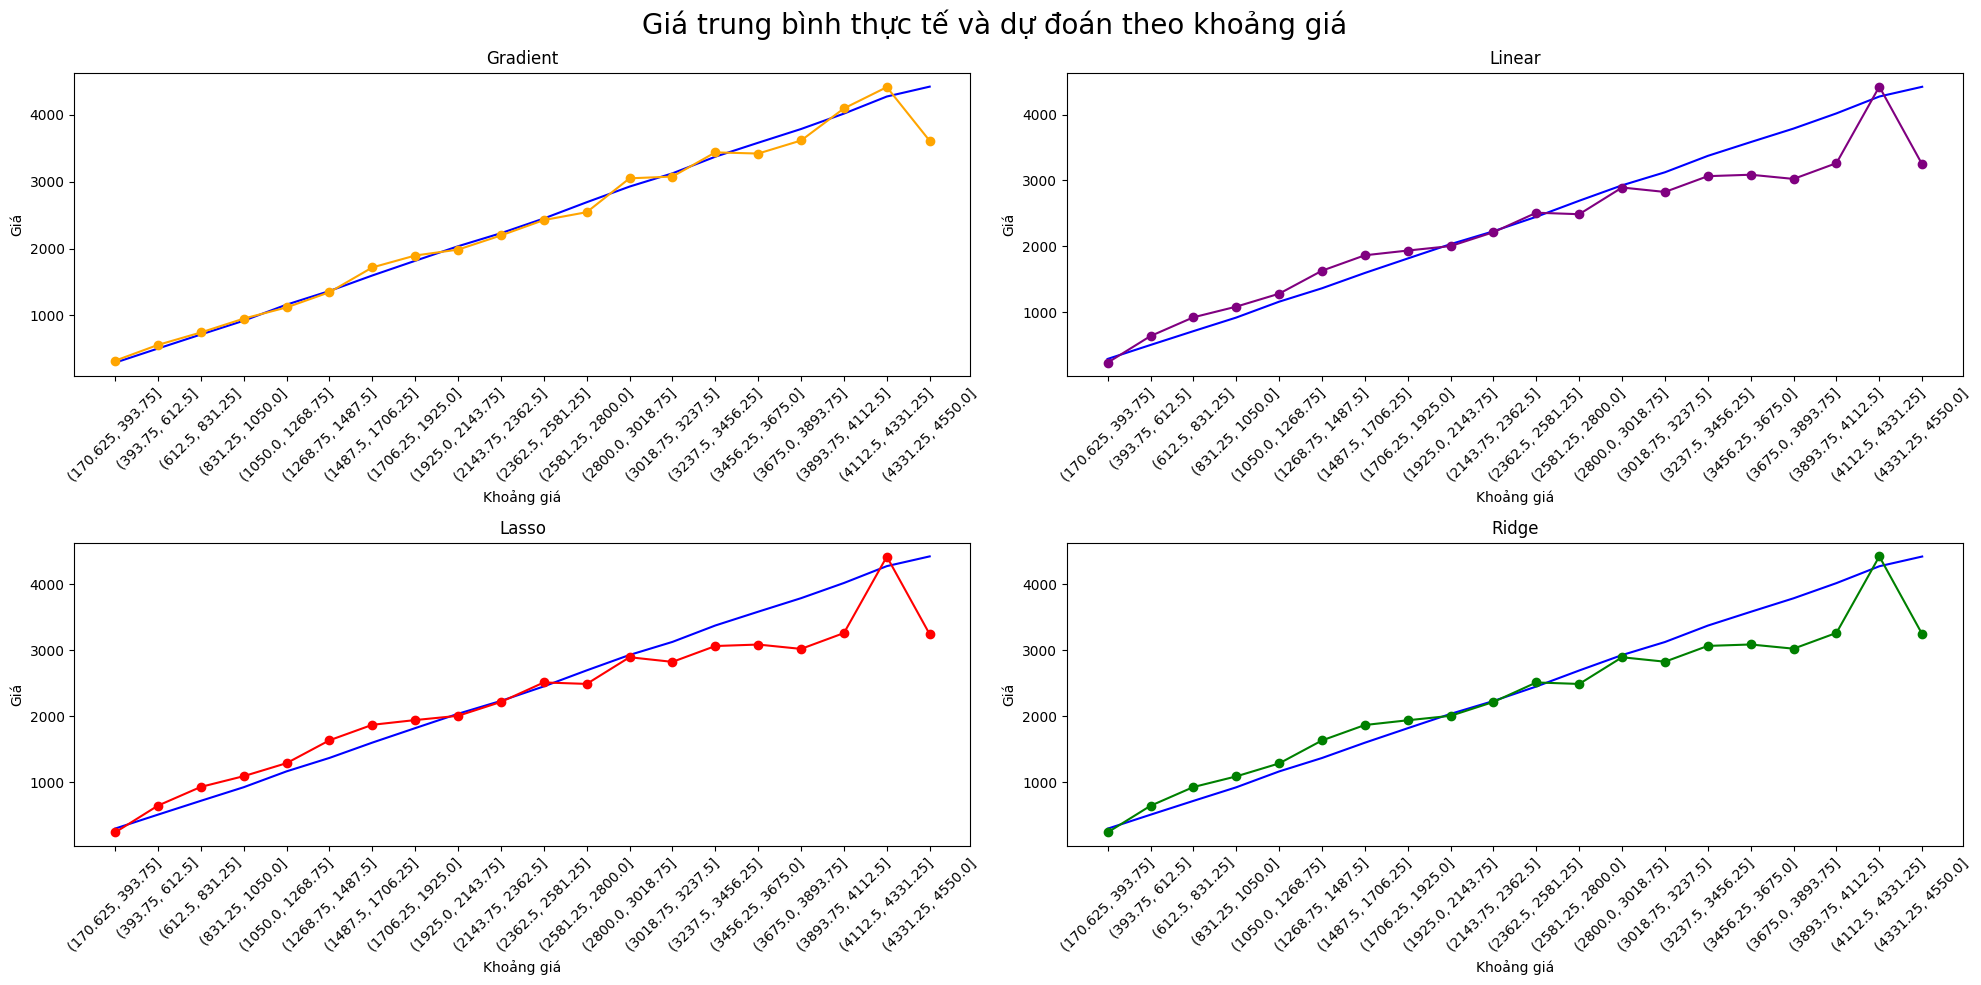

In [370]:
full_before_and_after_price = full_before_and_after_price.sort_values('Giá')

start_trim = full_before_and_after_price['Giá'].quantile(0.05)
end_trim = full_before_and_after_price['Giá'].quantile(0.97)

tmp = full_before_and_after_price[(full_before_and_after_price['Giá'] >= start_trim) & (full_before_and_after_price['Giá'] <= end_trim)]
bins = pd.cut(tmp['Giá'], 20)
average_prices = tmp.groupby(bins)[['Giá', 'Gradient', 'Linear', 'Lasso', 'Ridge']].mean()
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
plt.suptitle('Giá trung bình thực tế và dự đoán theo khoảng giá', size=20) 

axs[0, 0].plot(average_prices.index.astype(str), average_prices['Giá'], color='blue', label='Giá')
axs[0, 0].plot(average_prices.index.astype(str), average_prices['Gradient'], color='orange', marker='o')
axs[0, 0].set_title('Gradient')
axs[0, 0].set_xlabel('Khoảng giá')
axs[0, 0].set_ylabel('Giá')
axs[0, 0].tick_params(axis='x', rotation=45)

axs[0, 1].plot(average_prices.index.astype(str), average_prices['Giá'], color='blue', label='Giá')
axs[0, 1].plot(average_prices.index.astype(str), average_prices['Linear'], color='purple', marker='o')
axs[0, 1].set_title('Linear')
axs[0, 1].set_xlabel('Khoảng giá')
axs[0, 1].set_ylabel('Giá')
axs[0, 1].tick_params(axis='x', rotation=45)

axs[1, 0].plot(average_prices.index.astype(str), average_prices['Giá'], color='blue', label='Giá')
axs[1, 0].plot(average_prices.index.astype(str), average_prices['Lasso'], color='red', marker='o')
axs[1, 0].set_title('Lasso')
axs[1, 0].set_xlabel('Khoảng giá')
axs[1, 0].set_ylabel('Giá')
axs[1, 0].tick_params(axis='x', rotation=45)

axs[1, 1].plot(average_prices.index.astype(str), average_prices['Giá'], color='blue', label='Giá')
axs[1, 1].plot(average_prices.index.astype(str), average_prices['Ridge'], color='green', marker='o')
axs[1, 1].set_title('Ridge')
axs[1, 1].set_xlabel('Khoảng giá')
axs[1, 1].set_ylabel('Giá')
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Nhận xét:
- Các xe trong tầm giá khoảng 3 tỉ trở lên thì có sự sai lệch giá trong dự đoán tương đối cao (Do trong khoảng này có tương đối ít xe và giá biến động lớn)
- Mô hình Gradient có độ chính xác cao hơn so với các mô hình còn lại

Tỉ lệ sai trên giá trị thực của xe theo khoảng giá của tập validation

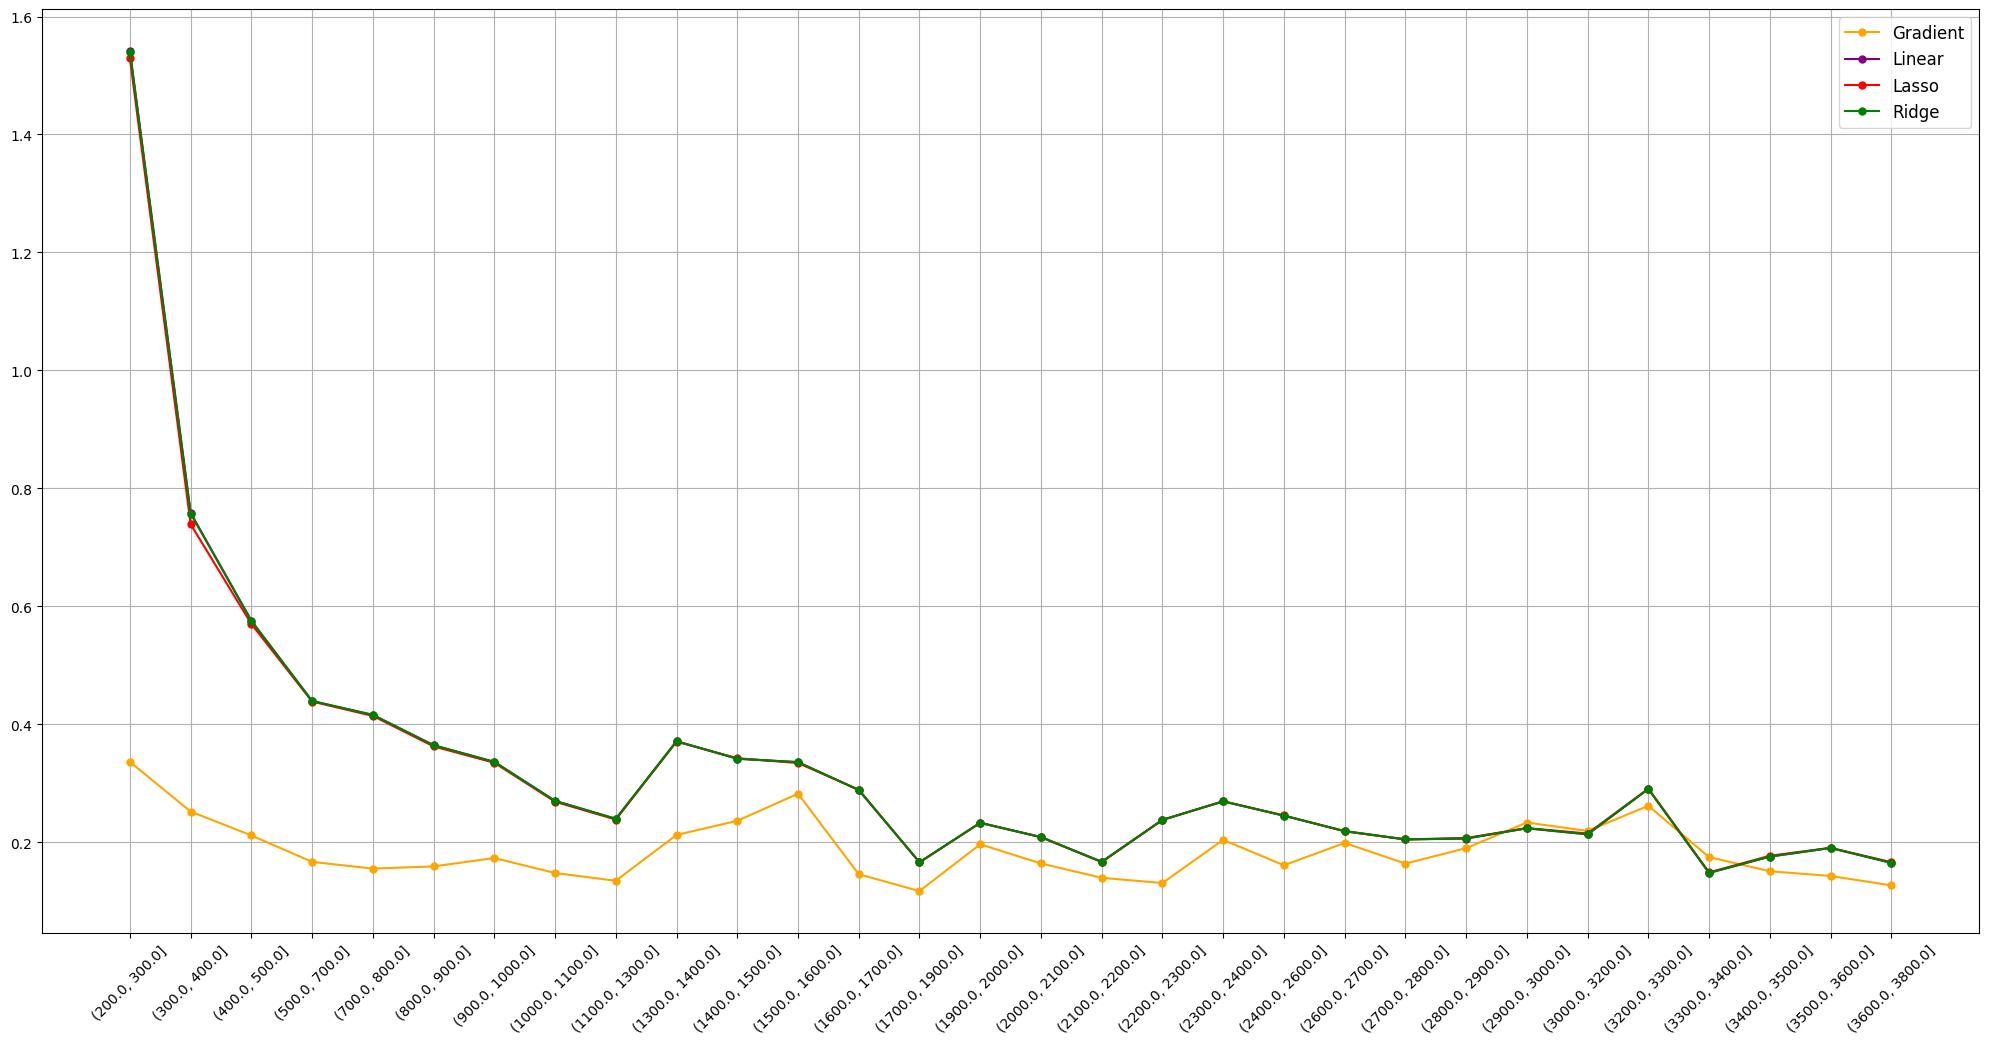

In [371]:
quantile_05 = full_before_and_after_price['Giá'].quantile(0.05)
quantile_95 = full_before_and_after_price['Giá'].quantile(0.95)

trimmed_data = full_before_and_after_price[(full_before_and_after_price['Giá'] >= quantile_05) & 
                                            (full_before_and_after_price['Giá'] <= quantile_95)]


trimmed_data['GradientError'] = abs((trimmed_data['Gradient'] - trimmed_data['Giá']) / trimmed_data['Giá'] )
trimmed_data['LinearError'] = abs((trimmed_data['Linear'] - trimmed_data['Giá']) / trimmed_data['Giá'] )
trimmed_data['LassoError'] = abs((trimmed_data['Lasso'] - trimmed_data['Giá']) / trimmed_data['Giá'] )
trimmed_data['RidgeError'] = abs((trimmed_data['Ridge'] - trimmed_data['Giá']) / trimmed_data['Giá'] )

bins = pd.cut(trimmed_data['Giá'], bins=30)

average_values = trimmed_data.groupby(bins).mean()

round_x = average_values.index.map(lambda x: f"({round(x.left, -2)}, {round(x.right, -2)}]")

plt.figure(figsize=(25, 12))

plt.plot(round_x, average_values['GradientError'], color='orange', marker='o', markersize=5, label='Gradient')
plt.plot(round_x, average_values['LinearError'], color='purple', marker='o', markersize=5, label='Linear')
plt.plot(round_x, average_values['LassoError'], color='red', marker='o', markersize=5, label='Lasso')
plt.plot(round_x, average_values['RidgeError'], color='green', marker='o', markersize=5, label='Ridge')

plt.legend()
plt.legend(fontsize='large')
plt.xticks(rotation=45)
plt.grid()
plt.show()


### Nhận xét:
- Xe có giá khoảng 200-500 triệu có tỉ lệ sai số cao (do đối với xe giá rẻ thì sai số / giá cao hơn, đối với xe giá lớn thì sai số / giá thấp hơn)
- Mô hình Gradient cho thấy tỉ lệ sai số thấp nhất so với các mô hình còn lại 

# Kết luận:
- Trong tất cả mô hình sử dụng thì mô hình XGBoost có điểm số và độ chính xác cao nhất
- Các mô hình còn lại có độ chính xác tương đối thấp 
- Các mô hình hoạt động ổn định ít bị hiện tương overfit